In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np
from DLC_for_WBFM.utils.general.postprocessing.utils_metadata import regionprops_one_volume_one_channel


Bad key "text.kerning_factor" on line 4 in
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from segmentation.util.utils_pipeline import perform_post_processing_2d

In [3]:
# fname = "/scratch/zimmer/Charles/dlc_stacks/project_pytest/project_config.yaml"
fname = "/home/charles/dlc_stacks/students-worm4-LOCAL/project_config.yaml"

project_data = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True, to_load_segmentation_metadata=True)

INFO:projectDataLogger:Starting threads to read data...
INFO:projectDataLogger:First time loading the all tracklets, may take a while...


File for mode automatic exists at precendence: 1/3
Read data from: /home/charles/dlc_stacks/students-worm4-LOCAL/3-tracking/postprocessing/combined_3d_tracks.h5


File for mode manual exists at precendence: 1/3
Read data from: /home/charles/dlc_stacks/students-worm4-LOCAL/3-tracking/manual_annotation/manually_split_tracklets-3.h5


  0%|          | 0/26890 [00:00<?, ?it/s]

INFO:projectDataLogger:Read all data


File for mode manual exists at precendence: 1/2
Read data from: /home/charles/dlc_stacks/students-worm4-LOCAL/3-tracking/manual_annotation/global2tracklet_manual-3.pickle
Project data for directory:
/home/charles/dlc_stacks/students-worm4-LOCAL 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
behavior_annotations:     True
============Training================
df_training_tracklets:    True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



# Try to automatically resegment using a hierarchy of methods:

1. Initially, just gaussian fitting (already tried)
2. If that fails, use centroid motion?
3. If that fails, use inner-product 

Also, try to split triple-squished neurons

## First, reproduce the segmentation from the used settings


In [446]:
ind = 53
t = 2
seg = project_data.raw_segmentation[t, ...]
red = project_data.red_data[t, ...]

In [447]:
seg_cfg = project_data.project_config.get_segmentation_config()
opt = seg_cfg.config['postprocessing_params']

In [448]:
new_seg = perform_post_processing_2d(seg, red, **opt)

  0%|          | 0/718 [00:00<?, ?it/s]

IndexError: index 18 is out of bounds for axis 0 with size 18

In [10]:
v = napari.view_labels(seg, ndisplay=3)
v.add_labels(new_seg, rendering='translucent')
v.add_image(red, colormap='PiYG')

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Image layer 'red' at 0x7fb85f57f850>

In [ ]:
old_props = regionprops_one_volume_one_channel(seg, red, ['intensity_image'], name_mode='neuron')
new_props = regionprops_one_volume_one_channel(new_seg, red, ['intensity_image'], name_mode='neuron')

In [51]:
# Get differences (should only be due to gaussian splitting initialization)
for k, v in new_props.items():
    v_old = old_props.get(k, None)
    if v_old is None:
        print(f"{k} is missing in the old set of neurons")
    elif v_old == v:
        pass
    else:
        print(f"Different values for {k[0]}: {v_old} != {v}")
        

Different values for neuron_022: 48640 != 32011
Different values for neuron_127: 17597 != 15158
Different values for neuron_129: 15007 != 12926


## Second, change the settings to fix known errors

In [8]:
# ind = 53
# t = 0
ind = 31
t = 1#68
seg = project_data.raw_segmentation[t, ...]
red = project_data.red_data[t, ...]

In [9]:
seg_cfg = project_data.project_config.get_segmentation_config()
opt = seg_cfg.config['postprocessing_params']

opt['min_separation'] = 20 # Force failure of splits

In [497]:
new_seg = perform_post_processing_2d(seg, red, **opt)

  0%|          | 0/718 [00:00<?, ?it/s]

In [498]:
%debug

> /tmp/ipykernel_55185/282779551.py(1)<module>()
----> 1 y = result.data
      2 x = np.arange(len(y))
      3 
      4 g1 = result.eval_components(x=np.array(x))['g1_']
      5 g2 = result.eval_components(x=np.array(x))['g2_']



ipdb>  q


In [281]:
v = napari.view_labels(seg, ndisplay=3)
v.add_labels(new_seg, rendering='translucent')
v.add_image(red, colormap='PiYG')

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Image layer 'red' at 0x7fb6df067c90>

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/layers/labels/labels.py:917: UserWarning: Contours are not displayed during 3D rendering
  deferred=True,
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/layers/labels/labels.py:917: UserWarning: Contours are not displayed during 3D rendering
  deferred=True,


In [500]:
old_props = regionprops_one_volume_one_channel(seg, red, ['intensity_image'], name_mode='neuron')
new_props = regionprops_one_volume_one_channel(new_seg, red, ['intensity_image'], name_mode='neuron')

In [501]:
# Get differences
for k, v in new_props.items():
    v_old = old_props.get(k, None)
    if v_old is None:
        print(f"{k} is missing in the old set of neurons")
    elif v_old == v:
        pass
    else:
        print(f"Different values; {k[0]}: old={v_old} != new={v}")
        

Different values; neuron_005: old=64745 != new=36150
Different values; neuron_008: old=40253 != new=37359
Different values; neuron_026: old=20712 != new=37669
Different values; neuron_031: old=52704 != new=50242
Different values; neuron_039: old=34455 != new=60377
Different values; neuron_043: old=39583 != new=48132
Different values; neuron_044: old=18906 != new=62364
Different values; neuron_046: old=54292 != new=64767
Different values; neuron_050: old=23614 != new=40342
Different values; neuron_059: old=19168 != new=31747
Different values; neuron_064: old=15658 != new=26810
Different values; neuron_065: old=30518 != new=48903
Different values; neuron_066: old=18005 != new=48144
('neuron_108', 'intensity_image') is missing in the old set of neurons
Different values; neuron_109: old=19257 != new=16960
Different values; neuron_110: old=16960 != new=21847
Different values; neuron_111: old=21847 != new=13869
Different values; neuron_112: old=13869 != new=20807
Different values; neuron_113

# Use package lmfit for multi-gaussian fitting and AIC comparison

https://lmfit.github.io/lmfit-py/builtin_models.html#example-1-fit-peak-data-to-gaussian-lorentzian-and-voigt-profiles

In [10]:
# First, rebuild the brightnesses as a function of z
from segmentation.util.utils_postprocessing import get_neuron_lengths_dict, calc_brightness

In [11]:
neuron_lengths = get_neuron_lengths_dict(seg)
brightnesses, neuron_planes = calc_brightness(red, seg, neuron_lengths)

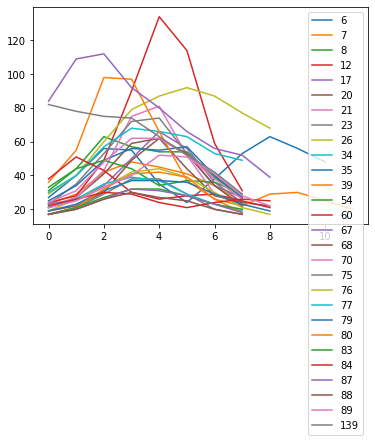

In [19]:
to_test = []
for k, b in brightnesses.items():
    if len(b) > 7:
        plt.plot(b, label=f"{k}")
        to_test.append(k)
plt.legend()

In [13]:
# # i = 50 # Should be 2
# i = 71 # Should be 1

# y = brightnesses[i]
# x = neuron_planes[i]
# plt.plot(x, y)

In [14]:
from lmfit.models import GaussianModel, ConstantModel

In [15]:
np.mean(y)

NameError: name 'y' is not defined

In [20]:
def aicc_correction(p, n):
    return 2*p*(p+1) / (n-p-1)

def compare_gaussian_fits(x, y):

    min_separation = 2
    # x, y = np.array(x), np.array(y)
    x, y = np.arange(len(x)), np.array(y)
    
    background = 14
    y -= background

    # background = ConstantModel()
    # pars = background.make_params()
    # pars['c'].set(value=np.min(y), min=14)
    # background = 14

    gauss1 = GaussianModel(prefix='g1_')
    pars = gauss1.make_params()
    # pars.update(gauss1.make_params())

    pars['g1_center'].set(value=len(y) / 4.0, min=0, max=len(y))
    pars['g1_sigma'].set(value=2.0, min=1, max=3)
    pars['g1_amplitude'].set(value=np.mean(y), min=0)

    gauss2 = GaussianModel(prefix='g2_')
    pars.update(gauss2.make_params())

    pars['g2_center'].set(value=3 * len(y) / 4.0, min=0, max=len(y))
    pars['g2_sigma'].set(value=2.0, min=1, max=3)
    pars['g2_amplitude'].set(value=np.mean(y), min=0)

    mod = gauss1 + gauss2# + background

    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)

    # print(out.fit_report(min_correl=0.5))

#     fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
#     axes[0].plot(x, y)
#     axes[0].plot(x, init, '--', label='initial fit')
#     axes[0].plot(x, out.best_fit, '-', label='best fit')
#     axes[0].legend()

#     comps = out.eval_components(x=x)
#     axes[1].plot(x, y)
#     axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
#     axes[1].plot(x, comps['g2_'], '--', label='Gaussian component 2')
#     axes[1].legend()

#     plt.show()

    results_2gauss = out
    

    gauss1 = GaussianModel(prefix='g1_')
    pars = gauss1.make_params()
    # pars.update(gauss1.make_params())
    pars['g1_center'].set(value=len(y) / 2.0, min=0, max=len(y))
    pars['g1_sigma'].set(value=2.0, min=1, max=3)
    pars['g1_amplitude'].set(value=np.mean(y), min=0)

    mod = gauss1

    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)

#     fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
#     axes[0].plot(x, y)
#     axes[0].plot(x, init, '--', label='initial fit')
#     axes[0].plot(x, out.best_fit, '-', label='best fit')
#     axes[0].legend()

#     comps = out.eval_components(x=x)
#     axes[1].plot(x, y)
#     axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
#     axes[1].legend()

#     plt.show()

    results_1gauss = out
    
    
#     gauss1 = GaussianModel(prefix='g1_')
#     pars = gauss1.make_params()
#     # pars.update(gauss1.make_params())

#     pars['g1_center'].set(value=len(y) / 4.0, min=0, max=len(y))
#     pars['g1_sigma'].set(value=min_separation/2, min=1, max=3)
#     pars['g1_amplitude'].set(value=np.mean(y), min=0)

#     gauss2 = GaussianModel(prefix='g2_')
#     pars.update(gauss2.make_params())

#     pars['g2_center'].set(value=3 * len(y) / 4.0, min=0, max=len(y))
#     pars['g2_sigma'].set(value=min_separation/2, min=1, max=3)
#     pars['g2_amplitude'].set(value=np.mean(y), min=0)
    
#     gauss3 = GaussianModel(prefix='g3_')
#     pars.update(gauss3.make_params())

#     pars['g3_center'].set(value=3 * len(y) / 4.0, min=0, max=len(y))
#     pars['g3_sigma'].set(value=min_separation/2, min=1, max=3)
#     pars['g3_amplitude'].set(value=np.mean(y), min=0)

#     mod = gauss1 + gauss2 + gauss3

#     init = mod.eval(pars, x=x)
#     out = mod.fit(y, pars, x=x)
    
#     fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
#     axes[0].plot(x, y)
#     axes[0].plot(x, init, '--', label='initial fit')
#     axes[0].plot(x, out.best_fit, '-', label='best fit')
#     axes[0].legend()

#     comps = out.eval_components(x=x)
#     axes[1].plot(x, y)
#     axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
#     axes[1].plot(x, comps['g2_'], '--', label='Gaussian component 2')
#     axes[1].plot(x, comps['g3_'], '--', label='Gaussian component 3')
#     axes[1].legend()

#     plt.show()

    results_3gauss = out
    
    return results_1gauss, results_2gauss, results_3gauss, axes


from segmentation.util.utils_postprocessing import calc_split_point_from_gaussians
def calc_split_point_from_gaussians2(result):
    peak1 = result.values['g1_center']
    peak2 = result.values['g2_center']
    y = result.data
    
    split_point = calc_split_point_from_gaussians(result)
    # split_point = calc_split_point_from_gaussians([int(np.floor(peak1)), int(np.ceil(peak2))], y)
    return split_point

Testing neuron 6
TWO GAUSSIANS


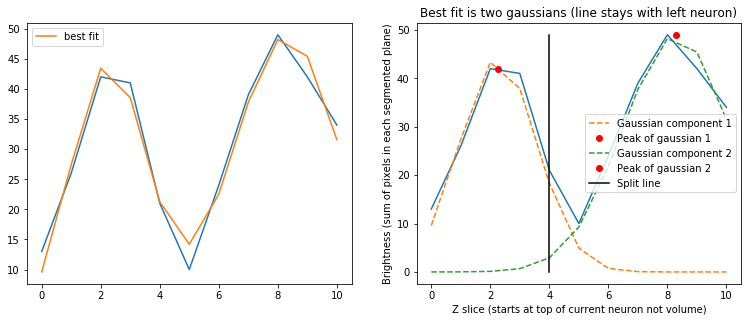

4
Testing neuron 7
ONE GAUSSIAN


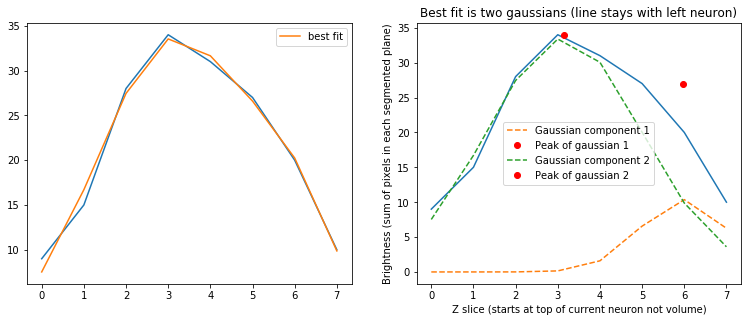

None
Testing neuron 8
ONE GAUSSIAN


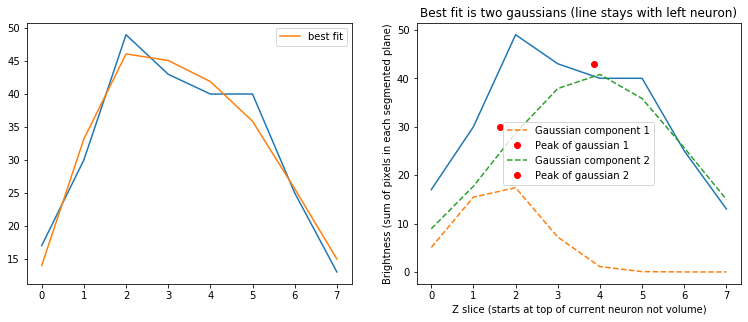

None
Testing neuron 12
ONE GAUSSIAN


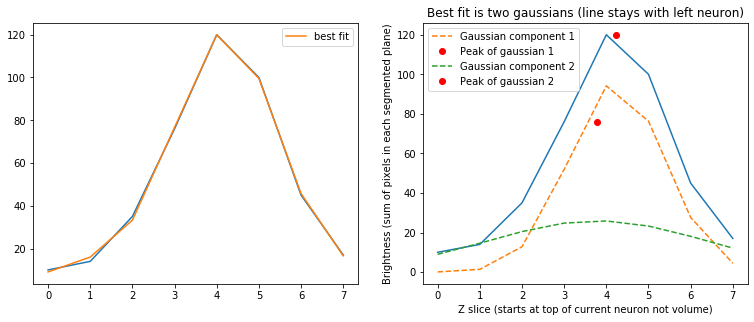

None
Testing neuron 17
ONE GAUSSIAN


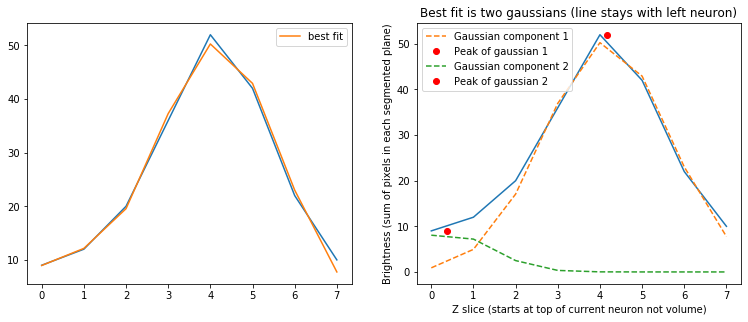

None
Testing neuron 20
ONE GAUSSIAN


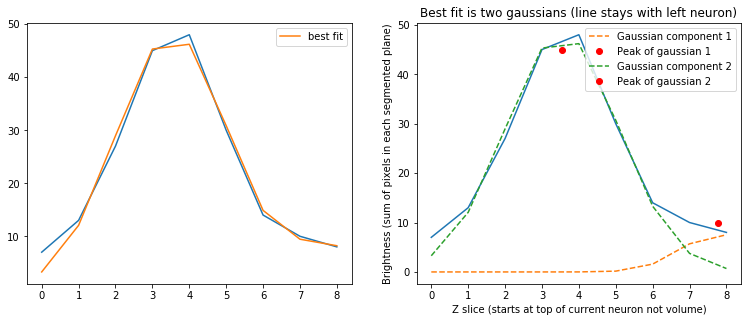

None
Testing neuron 21
ONE GAUSSIAN


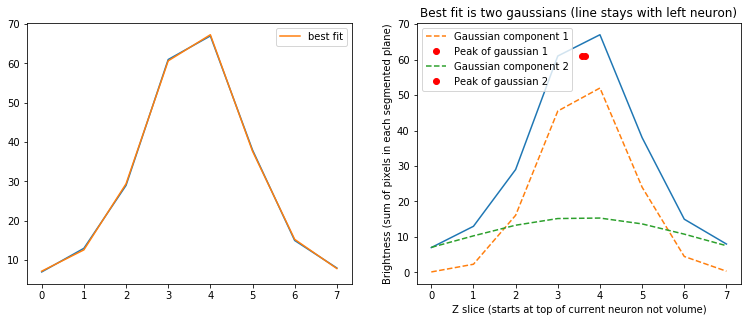

None
Testing neuron 23
ONE GAUSSIAN


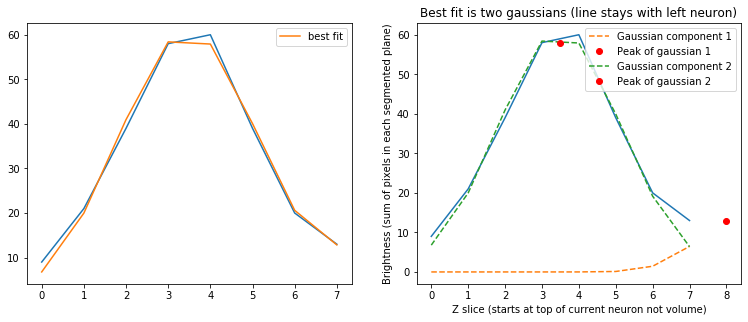

None
Testing neuron 26
ONE GAUSSIAN


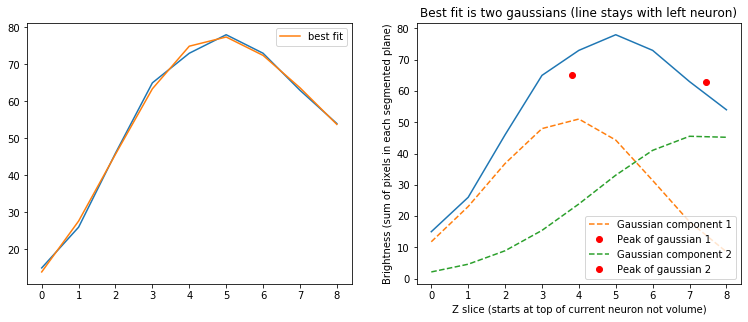

None
Testing neuron 34
ONE GAUSSIAN


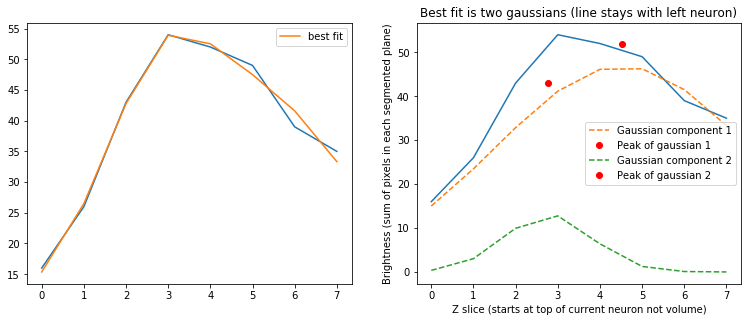

None
Testing neuron 35
ONE GAUSSIAN


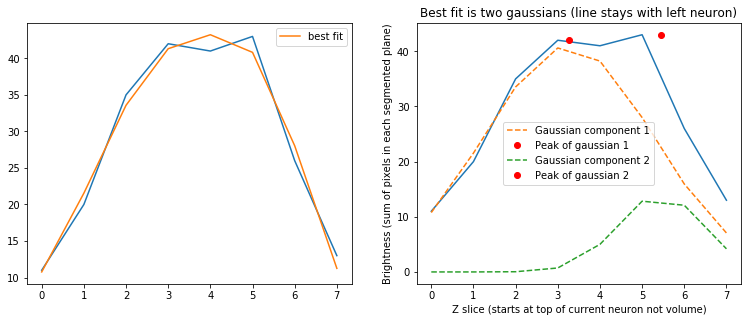

None
Testing neuron 39
TWO GAUSSIANS


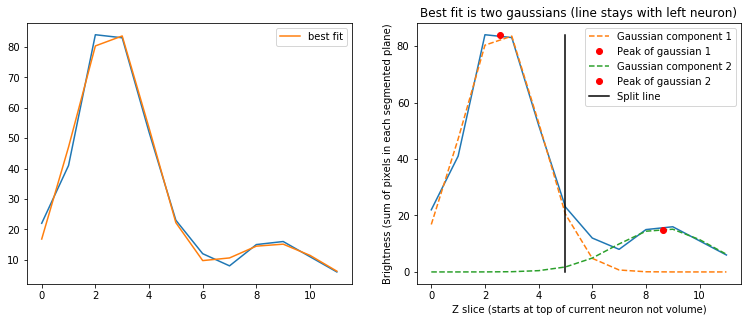

5
Testing neuron 54
ONE GAUSSIAN


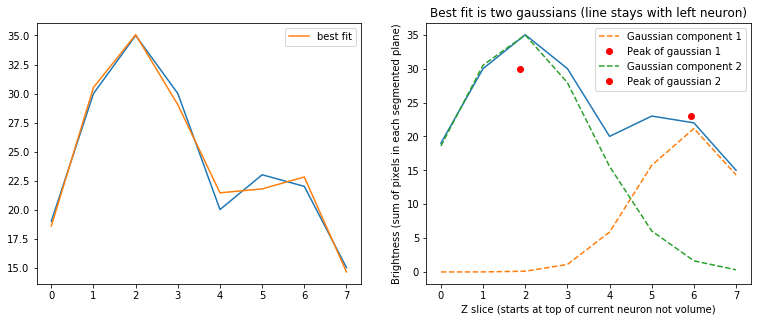

None
Testing neuron 60
TWO GAUSSIANS


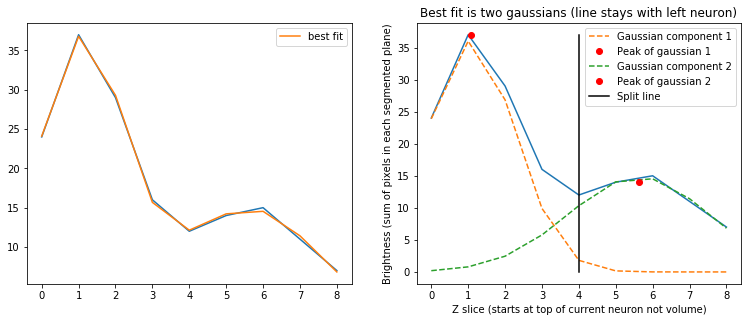

4
Testing neuron 67
ONE GAUSSIAN


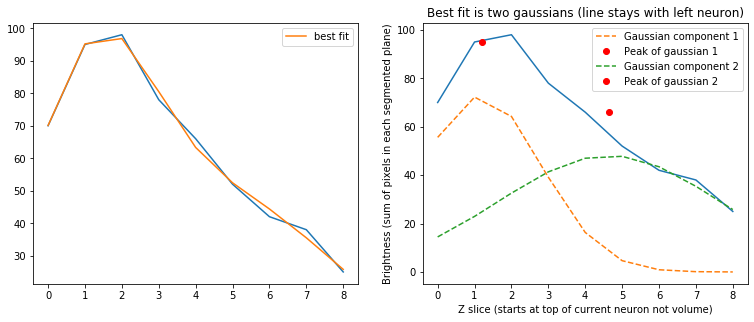

None
Testing neuron 68
ONE GAUSSIAN


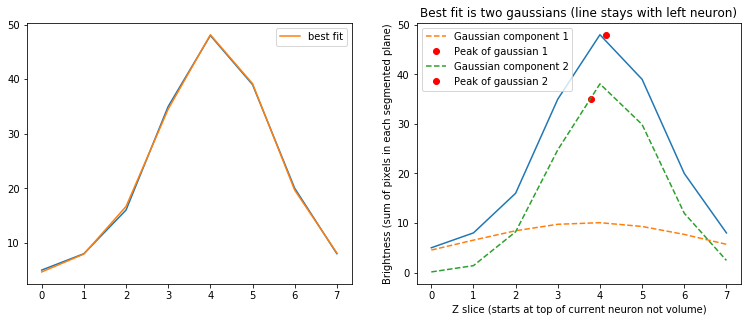

None
Testing neuron 70
ONE GAUSSIAN


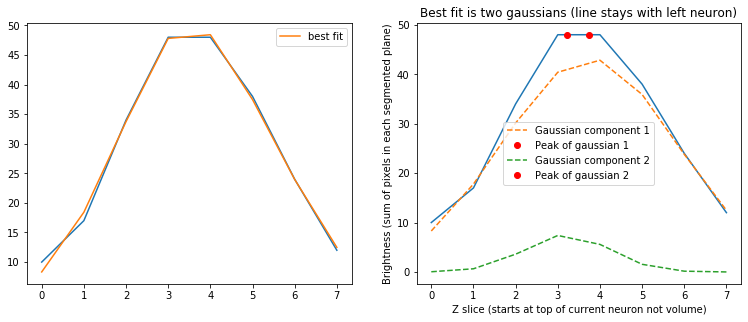

None
Testing neuron 75
ONE GAUSSIAN


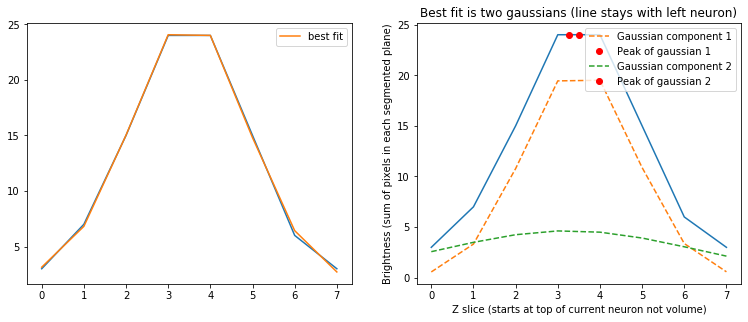

None
Testing neuron 76
ONE GAUSSIAN


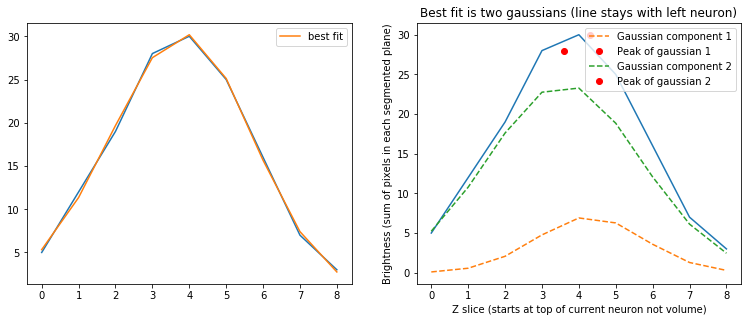

None
Testing neuron 77
ONE GAUSSIAN


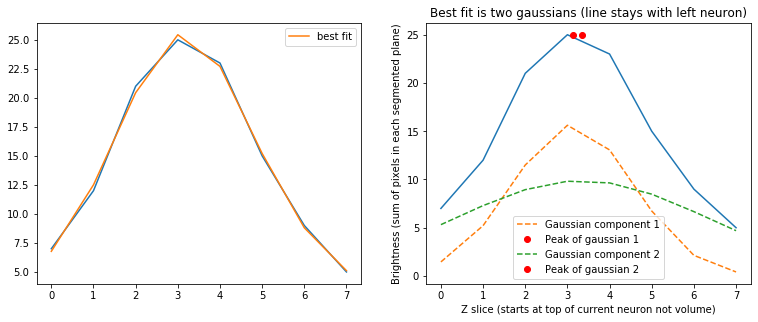

None
Testing neuron 79
ONE GAUSSIAN


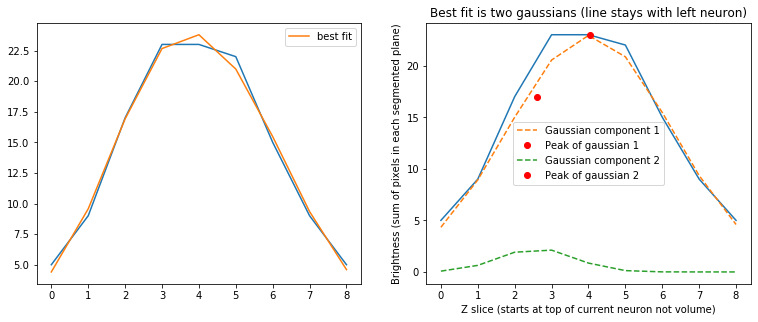

None
Testing neuron 80
ONE GAUSSIAN


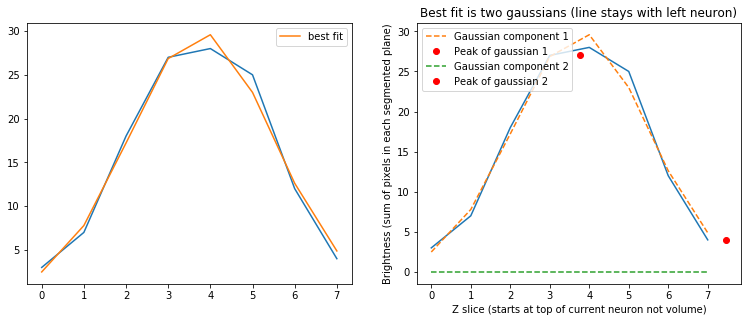

None
Testing neuron 83
ONE GAUSSIAN


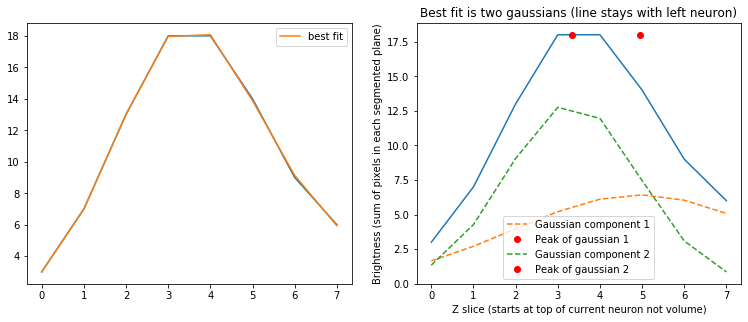

None
Testing neuron 84
ONE GAUSSIAN


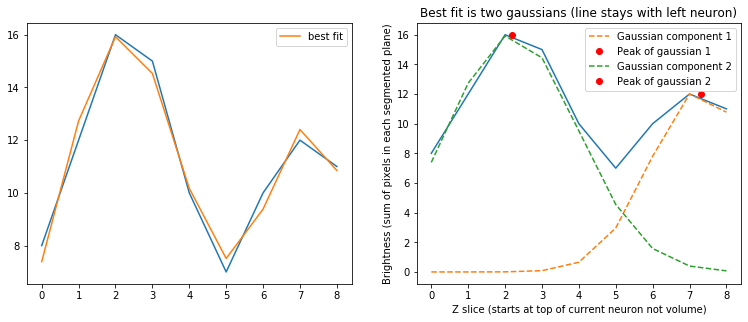

None
Testing neuron 87
ONE GAUSSIAN


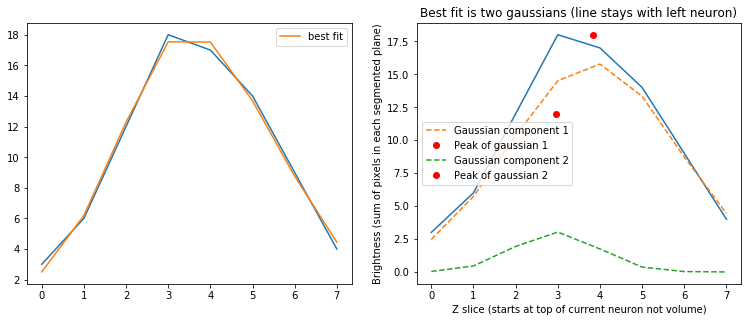

None
Testing neuron 88
ONE GAUSSIAN


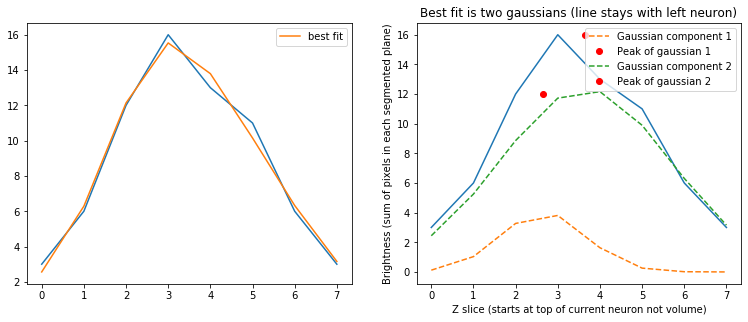

None
Testing neuron 89
ONE GAUSSIAN


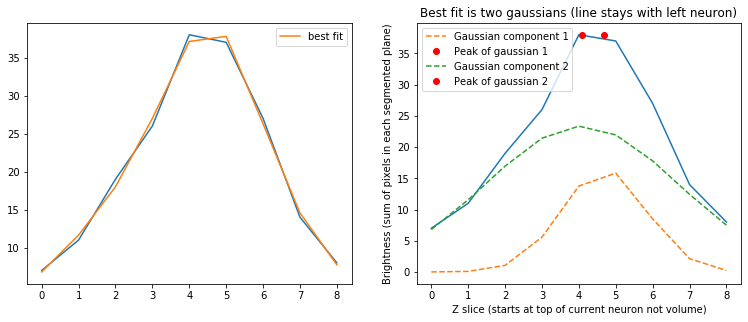

None
Testing neuron 139
ONE GAUSSIAN


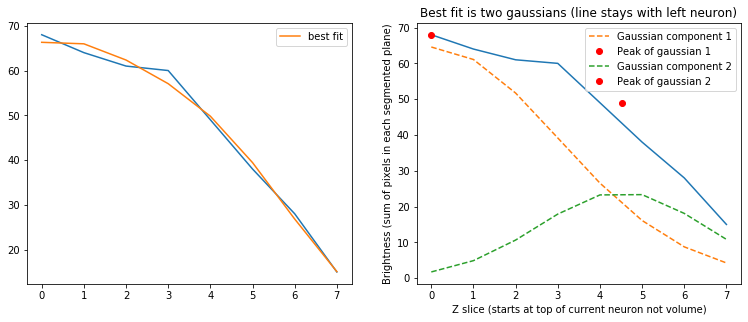

None


In [21]:
# to_test

from segmentation.util.util_curve_fitting import plot_gaussians, get_best_model_using_aicc, calculate_multi_gaussian_fits

for i in to_test:
    print("===================================================")
    print(f"Testing neuron {i}")
    print("===================================================")
    y = brightnesses[i]
    x = neuron_planes[i]

    # res1, res2, res3, axes = compare_gaussian_fits(x, y)
    list_of_models = calculate_multi_gaussian_fits(y, background=14)
    # list_of_models = [res1, res2]
    i_best = get_best_model_using_aicc(list_of_models)
    
    # aic1, aic2, aic3 = res1.aic, res2.aic, res3.aic
    # aicc1 = aic1 + aicc_correction(res1.nvarys, len(y))
    # aicc2 = aic2 + aicc_correction(res2.nvarys, len(y))
    # aicc3 = aic3 + aicc_correction(res3.nvarys, len(y))
    
    print("===================================================")
    if i_best == 0:
        print("ONE GAUSSIAN")
        split = None
    elif i_best == 1:
        print("TWO GAUSSIANS")
        # Also plot split point, IF ANY
        split = calc_split_point_from_gaussians(list_of_models[1])
    else:
        print("THREE GAUSSIANS")

    plot_gaussians(list_of_models[1], split)
    # axes[1].plot([split, split], [0, np.max(y)])
    print(split)
    # if split is None:
    #     break
    # plt.show()
    
    # print(aic1, aic2, aic3)
    # print(aicc1, aicc2, aicc3)
    print("===================================================")
    # break

In [535]:
# calc_split_point_from_gaussians(res2)

In [517]:
result = res2


y = result.data
x = np.arange(len(y))

g1 = result.eval_components(x=np.array(x))['g1_']
g2 = result.eval_components(x=np.array(x))['g2_']
diff = np.array(np.abs(g1 - g2))

peak1 = result.values['g1_center']
peak2 = result.values['g2_center']
if peak1 > peak2:
    peak1, peak2 = peak2, peak1
# print(peak1, peak2)
peaks_of_gaussians = [int(np.floor(peak1)), int(np.ceil(peak2))]

ind = peaks_of_gaussians[0] + np.array(range(0, peaks_of_gaussians[1] + 1))
ind = np.clip(ind, 0, len(diff)-1)
inter_peak_diff = np.array(diff[ind])

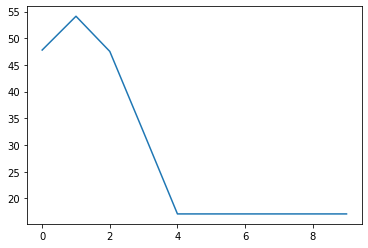

In [518]:
plt.plot(inter_peak_diff)

In [522]:
peak1, peak2

(4.989228237998518, 8.999960333112343)

In [520]:
find_peaks(inter_peak_diff)

(array([1]), {})

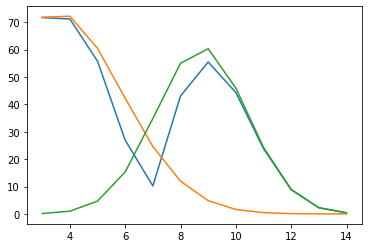

In [425]:
g1 = res2.eval_components(x=np.array(x))['g1_']
g2 = res2.eval_components(x=np.array(x))['g2_']
diff = np.array(np.abs(g1 - g2))

plt.plot(x, diff)
plt.plot(x, g1)
plt.plot(x, g2)

In [432]:

peak1 = res2.values['g1_center'] - x[0]
peak2 = res2.values['g2_center'] - x[0]
print(peak1, peak2)
peaks_of_gaussians = [int(np.floor(peak1)), int(np.ceil(peak2))]

ind = peaks_of_gaussians[0] + np.array(range(0,peaks_of_gaussians[1]+1))
inter_peak_diff = np.array(diff[ind])

0.5263479165951477 5.7526590168393295


In [536]:
# from scipy.signal._peak_finding import find_peaks
# find_peaks(inter_peak_diff)[0][0]

In [537]:
# res2.data

# Debug package functions

In [599]:
project_path = "/home/charles/dlc_stacks/students-worm4-LOCAL-resegment/project_config.yaml"
from DLC_for_WBFM.utils.projects.project_config_classes import ModularProjectConfig
from segmentation.util.utils_config_files import _unpack_config_file
from segmentation.util.utils_pipeline import *
from segmentation.util.utils_pipeline import _only_postprocess2d
from DLC_for_WBFM.utils.projects.utils_project import safe_cd

project_cfg = ModularProjectConfig(project_path)

In [613]:
segment_cfg = project_cfg.get_segmentation_config()
continue_from_frame = None
DEBUG=False

In [614]:
with safe_cd(project_cfg.project_dir):
    frame_list, mask_fname, metadata_fname, num_frames, _, verbose, video_path, zero_out_borders, all_bounding_boxes = _unpack_config_file(
        segment_cfg, project_cfg, DEBUG)

    check_all_needed_data_for_step(project_cfg.self_path, 2)
    masks_zarr = zarr.open(mask_fname)
    old_masks = np.array(masks_zarr[:10])
    masks_zarr = np.array(masks_zarr[:10])
    
    video_dat = zarr.open(video_path)

    opt_postprocessing = segment_cfg.config['postprocessing_params']  # Unique to 2d
    opt_postprocessing['already_stitched'] = True
    opt = {'masks_zarr': masks_zarr, 'opt_postprocessing': opt_postprocessing,
           'verbose': verbose,
           'all_bounding_boxes': all_bounding_boxes}
    if continue_from_frame is None:
        # Note that this does NOT have a separate 'do first volume' function
        continue_from_frame = 0

In [615]:
opt['verbose'] = 2

for i_both in enumerate(frame_list[continue_from_frame:]):
    i_out, i_vol = i_both
    print(i_both)
    _only_postprocess2d(i_out + continue_from_frame, i_vol, video_dat=video_dat, **opt)

(0, 0)
Starting preprocessing with 148 neurons
Note: not yet stitched in z
Removing large areas in all planes
After large area removal: 148
After stitching: 148
After splitting: 150
After short neuron removal: 150
After border removal: 151
Postprocessing finished
(1, 1)
Starting preprocessing with 140 neurons
Note: not yet stitched in z
Removing large areas in all planes
After large area removal: 140
After stitching: 140
After splitting: 140
After short neuron removal: 140
After border removal: 141
Postprocessing finished
(2, 2)
Starting preprocessing with 139 neurons
Note: not yet stitched in z
Removing large areas in all planes
After large area removal: 139
After stitching: 139
After splitting: 139
After short neuron removal: 139
After border removal: 140
Postprocessing finished
(3, 3)
Starting preprocessing with 148 neurons
Note: not yet stitched in z
Removing large areas in all planes
After large area removal: 148
After stitching: 148
After splitting: 148
After short neuron removal

In [610]:
frame_list = list(range(10))
continue_from_frame = 0

In [619]:
all_bounding_boxes

In [634]:
v = napari.view_labels(masks_zarr[:10])
v.add_labels(old_masks)

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Labels layer 'old_masks' at 0x7fb7d42f60d0>

In [603]:
i = 0

np.unique(np.where(np.abs(masks_zarr[i] - old_masks[i]) > 0, old_masks[i], -1))

array([-1], dtype=int32)

In [604]:
np.unique(np.where(old_masks[i]==13, masks_zarr[i], -1))

array([-1, 13], dtype=int32)

# Try to upsample a neuron in z

In [4]:
from skimage.measure import label, regionprops

In [5]:
t = 1

seg = project_data.raw_segmentation[t, ...]
red = project_data.red_data[t, ...]

In [34]:
i = 67 # 3

# i = [136, 35]
# i = [132, 23]

# i = 113

# i = 67

# i = [43, 138] # Was 3, then improperly split... could be good in xy

i = 10

In [35]:
# i = 53
this_neuron = np.where(seg==i, red, 0)

brightnesses = []
for z in range(seg.shape[0]):
    b = np.mean(this_neuron[z,...])
    if b > 0:
        brightnesses.append(b)

Text(0.5, 1.0, 'raw brightness')

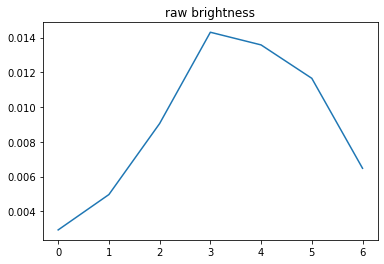

In [36]:
plt.plot(brightnesses)
plt.title('raw brightness')

In [37]:

i_target = 10
full_mask = seg
red_volume = red

planes_with_single_neuron = []
for i, plane in enumerate(full_mask):
    if i_target in plane:
        plane_mask = plane == i_target
        plane_red = red_volume[i]
        planes_with_single_neuron.append(np.where(plane_mask, plane_red, 0))
all_dots = []
for i in range(len(planes_with_single_neuron) - 1):
    all_dots.append(np.linalg.norm(planes_with_single_neuron[i] * planes_with_single_neuron[i + 1]))

Text(0.5, 1.0, 'dot product')

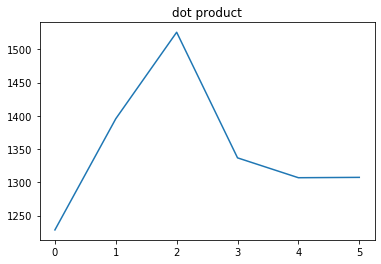

In [38]:
plt.plot(all_dots)
plt.title('dot product')

In [98]:
# i = 10

i = 67
this_neuron = np.where(seg==i, red, 0)
this_mask = np.where(seg==i, seg, 0)

xy = []
for z in range(seg.shape[0]):
    b = np.mean(this_neuron[z,...])
    if b > 0:
        props = regionprops(this_mask[z,...])
        xy.append(props[0].centroid)
xy = np.array(xy)

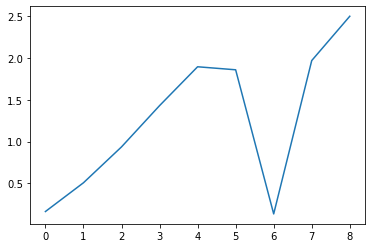

In [99]:
sum_of_grads = np.abs(np.gradient(xy[:, 0])) + np.abs(np.gradient(xy[:, 1]))
plt.plot(sum_of_grads)

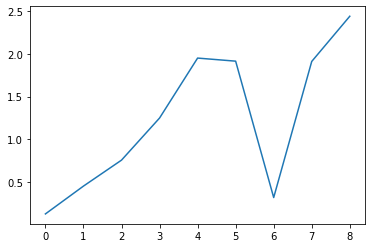

In [100]:
grad_x = np.gradient(xy[:, 0])
grad_x -= np.mean(grad_x)
grad_y = np.gradient(xy[:, 1])
grad_y -= np.mean(grad_y)
sum_of_grads = np.abs(grad_x) + np.abs(grad_y)
plt.plot(sum_of_grads)

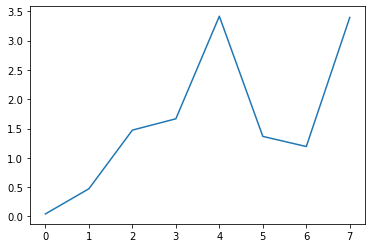

In [101]:
grad_x = np.diff(xy[:, 0])
grad_x -= np.mean(grad_x)
grad_y = np.diff(xy[:, 1])
grad_y -= np.mean(grad_y)
sum_of_grads = grad_x**2 + grad_y**2
plt.plot(sum_of_grads)

# View results from function

In [656]:
fname = '/home/charles/dlc_stacks/students-worm4-LOCAL-resegment/1-segmentation/masks.zarr'
z_new = zarr.open(fname)[:5, ...]
v = napari.view_labels(z_new, ndisplay=3)

fname = '/home/charles/dlc_stacks/students-worm4-LOCAL-resegment/1-segmentation/masks-backup.zarr'
z_backup = zarr.open(fname)[:5, ...]
v = v.add_labels(z_backup)

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


In [654]:
out = np.array(z2[:5, ...])

In [655]:
np.equal(z_new[0], z_backup[0]).all()

False

In [183]:
from sklearn.model_selection import cross_val_score, cross_validate

In [185]:
# def residual_score(model, x, y):
#     return np.linalg.norm(model.eval(x=x) - y)

# scores = cross_validate(mod, x, y, cv=5, scoring=residual_score)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [181]:
mod.eval(x=x) - y

array([-17.20211544, -17.51605855, -20.89201807, -24.9911363 ,
       -32.99973234, -36.99999703, -37.99999999, -35.        ,
       -28.        , -22.        , -19.        ])

In [217]:
from sklearn import mixture
from sklearn.preprocessing import StandardScaler


In [235]:
x2 = x.reshape(-1,1)
scaler = StandardScaler()
y2 = scaler.fit_transform(y.reshape(-1,1))
y2 -= np.min(y2)

gmm1 = mixture.GaussianMixture(
    n_components=1, means_init=np.array([[len(y)/2.0]]).T, covariance_type='diag'
)
gmm1.fit(y2)
gmm1.bic(y2)

36.012438276105044

In [236]:
gmm2 = mixture.GaussianMixture(
    n_components=2, means_init=np.array([[len(y)/4.0, 3*len(y)/4.0]]).T, covariance_type='diag'
)
gmm2.fit(y2)
gmm2.bic(y2)

43.20612388656385

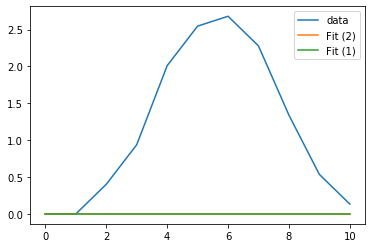

In [237]:
x2 = x.reshape(-1,1)

plt.plot(x2, y2, label="data")
plt.plot(gmm2.predict(x2), label="Fit (2)")
plt.plot(gmm1.predict(x2), label="Fit (1)")
plt.legend()